In [2]:
from sklearn.datasets import fetch_openml
# sklearn.datasets have 3 kinds of options fetch_, make_, load_

mnist = fetch_openml('mnist_784', as_frame= False)


In [3]:
X,y = mnist.data, mnist.target
X.shape
# 70000 images and 28*28 pixels for each of them

(70000, 784)

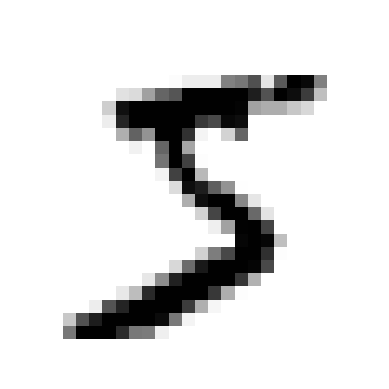

5


In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print(y[0])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Binary Classification

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

# [ random_state = <num> ] Starts randomness from this exact point in the sequence.
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [8]:
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# Performance Measure

# Cross-Validaiton
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [10]:
# Dummy - Classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train,y_train_5)
print(any(dummy_clf.predict(X_train))) # print(any) prints any true thing i think

False


In [11]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset isnot already shuffled

for train_index, test_index in skfolds.split(X_train,y_train_5):

    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


In [13]:
# Confusion Matrix
# To count the number of times class A are classified as class B

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm
# First Row is for non 5 numbers so 53892 is the number of correct predictions and 687 is 
# wrong classification for non 5's

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_pred_dummy = cross_val_predict(dummy_clf, X_train, y_train_5,cv=3)
cm_dummy = confusion_matrix(y_train_pred_dummy,y_train_5)
cm_dummy

array([[54579,  5421],
       [    0,     0]])

In [17]:
cm_ideal = confusion_matrix(y_train_5, y_train_5)
cm_ideal

array([[54579,     0],
       [    0,  5421]])

In [18]:
# Precision: True Positive, True Negative, False Positive, False Negative 
#            Precision measures the True Positive out of all the Positive Predictions ur model made
#            So TP/(TP + FP)

# Recall: Here we see the accuracy of positive cases of the model, 
#         Out of all positive cases how did the model detect
#         So TP/(TP + FN)

# Precision Classifier
from sklearn.metrics import precision_score, recall_score

# We pass in the predicted matrix using cross-validation
print(precision_score(y_train_5,y_train_pred)) 
print(recall_score(y_train_5,y_train_pred))

# When it claims an image represents a 5, it is correct only 83.7%
# of the time. Moreover, it only detects 65.1% of the 5s

0.8370879772350012
0.6511713705958311


In [19]:
# F1 Score 
# Harmonic mean of precision and recall

from sklearn.metrics import f1_score
print(f1_score(y_train_5,y_train_pred))

# Favors classifiers that have similar precision and recall

0.7325171197343847


In [20]:
# Precision/Recall Trade-off
# So different use cases need different thresholds to work with so there are 3 classifications 
# Low,Medium and High threshold which varies as precision increases from low to high and recall decreases
# Now the decision_function can be used to see the threshold for each of these cases or catergoring them

y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [21]:
# Better Precision and Poor Recall
threshold = 3000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")


In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

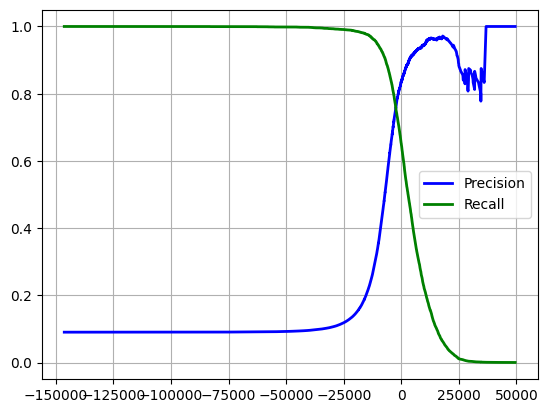

In [24]:
plt.plot(thresholds, precisions[:-1], "b-", label="Precision",
linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall",
linewidth=2)
plt.legend()
plt.grid()
plt.show()

# Recall is more bumpier cause it is ig .... see example in book page 201

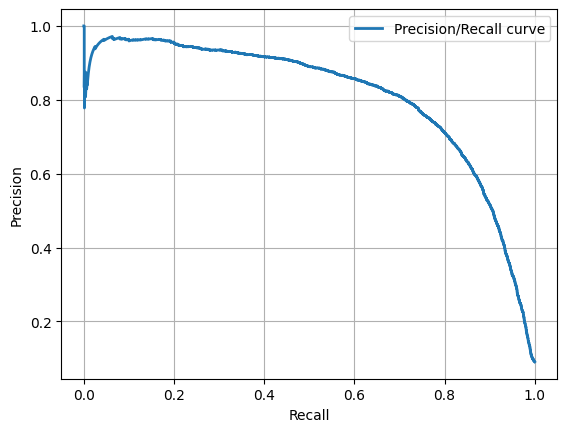

In [25]:
plt.plot(recalls, precisions, linewidth=2,label="Precision/Recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.grid()
plt.show()

In [26]:
# Using the right threshold for use case

idx_for_prediction = (precisions >= 0.90).argmax() # Finds the first index which satisfies the same
threshold_for_90_precision = thresholds[idx_for_prediction]
y_train_pred_90 = y_scores > threshold_for_90_precision
print(f"Precision score : {precision_score(y_train_5,y_train_pred_90)}") # order matters
print(f"Recall score : {recall_score(y_train_5,y_train_pred_90)}") 

Precision score : 0.9
Recall score : 0.47980077476480354


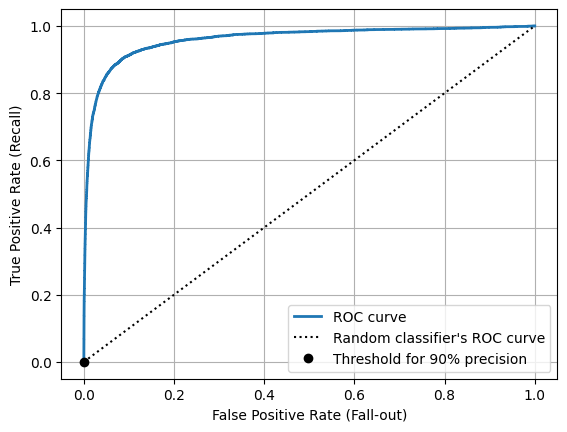

In [27]:
# ROC Curve
# Recall(tpr) vs Fall-out(fpr) instead of Recall vs Precision

from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5,y_scores)

idx_for_threshold_at_90 = (thresholds <=threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.xlabel("False Positive Rate (Fall-out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3, method="predict_proba")

In [ ]:
y_proba_forest[:2] # First row represents as 11% as negative and 89% is positive

array([[0.11, 0.89],
       [0.98, 0.02]])

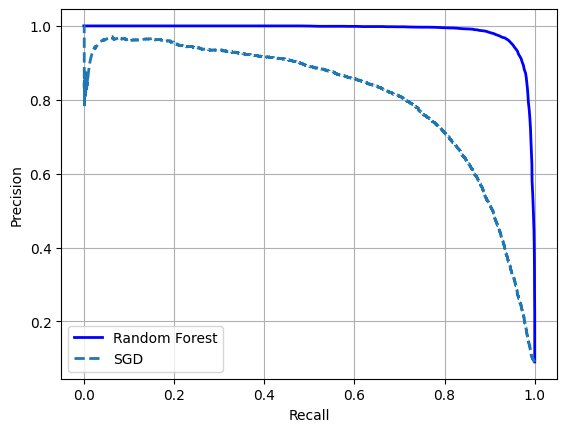

In [40]:
y_scores_forest = y_proba_forest[:,1]
precisions_forest , recalls_forest, thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions,
"--"
, linewidth=2, label="SGD")
plt.legend()
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [47]:
y_train_pred_forest = y_proba_forest[:, 1] >= 0.5
print(f"F1 Score: {f1_score(y_train_5, y_train_pred_forest)}\nROC Score: {roc_auc_score(y_train_5,y_scores)}")


F1 Score: 0.9270445185330457
ROC Score: 0.9604938554008616
